In [31]:
from openai import OpenAI
client = OpenAI(
    api_key='sk-84acb19aeb6648f0b4570fd57b82d84b',
    base_url='https://api.deepseek.com/v1'
)

In [32]:
# 导入sqlite3库
import sqlite3
# 连接到测试数据库(如果不存在则创建)
conn = sqlite3.connect("test_db.db")
# 创建一个 游标对象
# 游标用于执行 SQL 语句 获取查询结果
cursor = conn.cursor()
# 创建示例表
cursor.execute(""" 
CREATE TABLE IF NOT EXISTS 
employees ( 
id INTEGER PRIMARY KEY, 
name TEXT, 
department TEXT, 
salary INTEGER )""")

# 插入示例数据
# 列表 
# 每个 ( ..., ..., ..., ... ) 是一个 tuple
# Python 没有内置“数组”类型，通常用 list；
sample_data = [ 
    (6, "黄佳", "销售", 50000), 
    (7, "宁宁", "工程", 75000), 
    (8, "谦谦", "销售", 60000), 
    (9, "悦悦", "工程", 80000), 
    (10, "黄仁勋", "市场", 55000)
]

cursor.executemany("INSERT INTO employees VALUES (?, ?, ?, ?)", sample_data)
conn.commit()


In [33]:
# 获取数据库Schema
# Schema 应详细描述每个表的字段和类型，
# 这有助于 Claude 理解表的结构和关联。
# SQLite命令，查看employees表的列名、类型等结构信息。
schema = cursor.execute("PRAGMA table_info(employees)").fetchall()
print(schema)
# 列表推导式
# 使用 f-string（格式化字符串字面量），将列名和类型拼接成一个字符串。
schema_str = "CREATE TABLE EMPLOYEES (\n" + "\n".join([f"{col[1]} {col[2]}" for col in schema]) + "\n)"
print("数据库Schema:")
print(schema_str)

[(0, 'id', 'INTEGER', 0, None, 1), (1, 'name', 'TEXT', 0, None, 0), (2, 'department', 'TEXT', 0, None, 0), (3, 'salary', 'INTEGER', 0, None, 0)]
数据库Schema:
CREATE TABLE EMPLOYEES (
id INTEGER
name TEXT
department TEXT
salary INTEGER
)


In [34]:
# 定义一个函数,将查询发送给Deepseek并获取响应
def ask_claude(query, schema): 
    prompt = f"""这是一个数据库的Schema:
    {schema}
    根据这个Schema，请输出一个SQL查询来回答以下问题。
    只输出 SQL 查询语句本身，不要使用任何 Markdown 格式，不要包含反引号、代码块标记或额外说明。
    问题:{query}""" 
    response = client.chat.completions.create(
        model="deepseek-chat",
        max_tokens=2048,
        messages=[{
            "role": "user",
            "content": prompt
        }]
    )
    return response.choices[0].message.content

In [35]:
question = "工程部门员工的姓名和工资是多少?"
# 将问题发送给Claude并获取SQL查询
sql_query = ask_claude(question, schema_str)
print("生成的SQL查询:")
print(sql_query)

生成的SQL查询:
SELECT name, salary FROM EMPLOYEES WHERE department = '工程';


In [38]:
print("查询结果:")
results = cursor.execute(sql_query).fetchall()

for row in results: 
    print(row)
# 关闭数据库连接
# conn.close()

查询结果:


ProgrammingError: Cannot operate on a closed database.

In [39]:
cursor = conn.cursor()
conn = sqlite3.connect("test_db.db")
question = "在销售部门增加一个新员工,姓名为张三,工资为45000"
sql_query = ask_claude(question, schema_str)
print(sql_query)
cursor.execute(sql_query)
conn.commit()

INSERT INTO EMPLOYEES (id, name, department, salary) VALUES (NULL, '张三', '销售', 45000);


In [40]:
# 更新员工信息
question = "将黄佳的工资调整为55000"
sql_query = ask_claude(question, schema_str)
print(sql_query)
cursor.execute(sql_query)
conn.commit()

UPDATE EMPLOYEES SET salary = 55000 WHERE name = '黄佳';


In [25]:
# 删除员工
question = "删除市场部门的黄仁勋"
sql_query = ask_claude(question, schema_str)
print(sql_query)
cursor.execute(sql_query)
conn.commit()

DELETE FROM EMPLOYEES WHERE department = '市场' AND name = '黄仁勋';


In [43]:
question = "查询所有员工的信息"
sql_query = ask_claude(question, schema_str)
print(sql_query)
print("查询结果:")
results = cursor.execute(sql_query).fetchall()

for row in results: 
    print(row)

SELECT * FROM EMPLOYEES;
查询结果:
(6, '黄佳', '销售', 55000)
(7, '宁宁', '工程', 75000)
(8, '谦谦', '销售', 60000)
(9, '悦悦', '工程', 80000)
(10, '黄仁勋', '市场', 55000)
(11, '张三', '销售', 45000)


In [44]:
# 创建部门表
cursor.execute("""
    CREATE TABLE IF NOT EXISTS departments (
        id INTEGER PRIMARY KEY,
        name TEXT,
        manager TEXT
    )
""")

# 插入示例数据
sample_departments = [
    (1, "销售", "王经理"),
    (2, "工程", "李经理"),
    (3, "市场", "张经理")
]
cursor.executemany("INSERT INTO departments VALUES (?, ?, ?)", sample_departments)
conn.commit()

IntegrityError: UNIQUE constraint failed: departments.id

In [46]:
question = "查询所有departments表的信息"
sql_query = ask_claude(question, schema_str)
print(sql_query)
print("查询结果:")
results = cursor.execute(sql_query).fetchall()

for row in results: 
    print(row)

SELECT * FROM DEPARTMENTS;
查询结果:
(1, '销售', '王经理')
(2, '工程', '李经理')
(3, '市场', '张经理')


In [47]:
# 获取完整的数据库schema
tables = ["employees", "departments"]
schema_str = ""
for table in tables:
    schema = cursor.execute(f"PRAGMA table_info({table})").fetchall()
    schema_str += f"CREATE TABLE {table} (\n" + "\n".join([f"{col[1]} {col[2]}" for col in schema]) + "\n);\n\n"

print("完整的数据库schema:")
print(schema_str)

完整的数据库schema:
CREATE TABLE employees (
id INTEGER
name TEXT
department TEXT
salary INTEGER
);

CREATE TABLE departments (
id INTEGER
name TEXT
manager TEXT
);




In [48]:
# 查询每个部门的员工人数和平均工资
question = "根据两个表之间的关系,列出每个部门的员工人数和平均工资"
# 将问题发送给Claude并获取SQL查询
sql_query = ask_claude(question, schema_str)
print("生成的SQL查询:")
print(sql_query)
# GROUP BY 分组 按部门分组 d 
# order by 排序
# COUNT 计数字
# AVG 平均数
# LEFT JOIN 会返回左表的所有记录，即使右表中没有匹配的行；右表无匹配时，对应字段显示为 NULL。

生成的SQL查询:
SELECT d.name AS department_name, COUNT(e.id) AS employee_count, AVG(e.salary) AS average_salary
FROM departments d
LEFT JOIN employees e ON d.name = e.department
GROUP BY d.name, d.id
ORDER BY d.id;


In [49]:
# 执行SQL查询并打印结果
print("查询结果:")
results = cursor.execute(sql_query).fetchall()

for row in results:
    print(row)

# 关闭数据库连接
conn.close()

查询结果:
('销售', 3, 53333.333333333336)
('工程', 2, 77500.0)
('市场', 1, 55000.0)


findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
/tmp/ipykernel_1140/3124068702.py:28: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.savefig('Average_Salary_by_Department.png')
/tmp/ipykernel_1140/3124068702.py:28: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  plt.savefig('Average_Salary_by_Department.png')
/tmp/ipykernel_1140/3124068702.py:28: UserWarning: Glyph 24037 (\N{CJK UNIFIED IDEOGRAPH-5DE5}) missing from font(s) DejaVu Sans.
  plt.savefig('Average_Salary_by_Department.png'

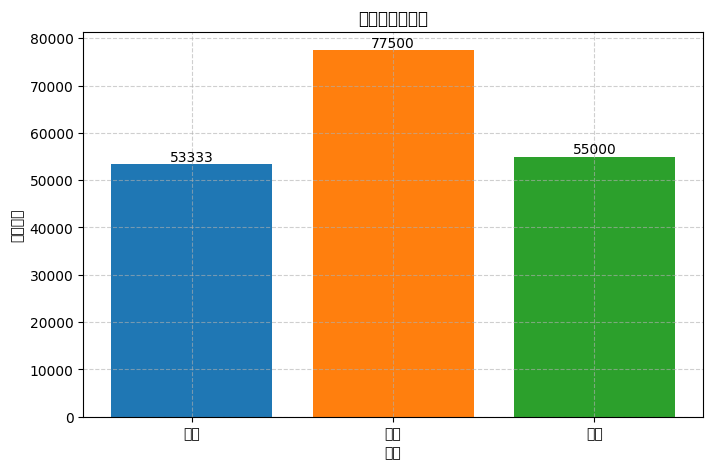

In [50]:
# 数据可视化库 Matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.family"]=['SimHei'] # 用来设定字体样式
plt.rcParams['font.sans-serif']=['SimHei'] # 用来设定无衬线字体样式
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号

# 计算平均工资
# 部门
departments = [row[0] for row in results]
# 工资
avg_salaries = [row[2] for row in results]

# 生成条形图
# 创建一个新的图形窗口（figure），并指定其宽度为 8 英寸、高度为 5 英寸
plt.figure(figsize=(8, 5))
#柱状图
bars = plt.bar(departments, avg_salaries, color=['#1f77b4', '#ff7f0e', '#2ca02c'])  # 为每个部门设置不同的颜色

# 设置图表标题和标签
plt.xlabel("部门")
plt.ylabel("平均工资")
plt.title("各部门平均工资")

# 添加网格线，提高图表的可读性
plt.grid(True, linestyle='--', alpha=0.6)

# 在每个条形图上方显示具体数值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval)}', va='bottom', ha='center', color='black')

# 保存图表到文件
plt.savefig('Average_Salary_by_Department.png')